**Chapter 2 End-to-End Project**

# Get the Data

## Download the Data

In [159]:
import os
import tarfile
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data (housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    
    os.makedirs(housing_path, exist_ok = True)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [3]:
def load_housing_data (housing_path = HOUSING_PATH):
    
    csv_path = os.path.join(housing_path, "housing.csv")
    
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()

## Taking a Quick Look at the Data Structure

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


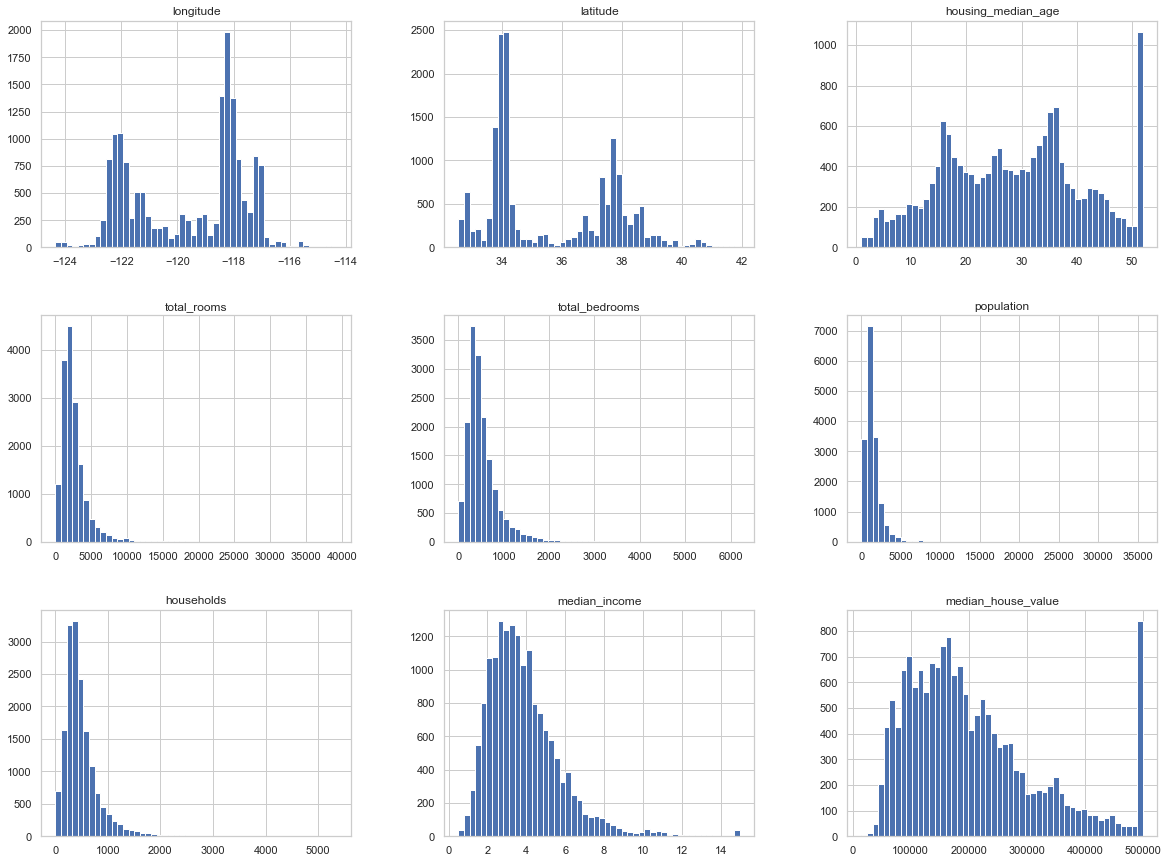

In [160]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

We don't want to look too closely at the data, because doing so can cause to see patterns and thus bias the models/algorithms we use and the approaches we take.

A quick look at the data structure and histograms are sufficient to tell us how the data is structured, and potential cleaning/wrangling we will need to undertake.

## Creating a test set

In [11]:
def split_train_test (data, test_ratio):
    
    shuffled_indices = np.random.permutation(len(data))
    
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

To have a stable train/test split. we compute a hash of each instance's unique identifier, and add the instance to the test set if the resulting hash is less than `test_ratio` times the max hash value.

The `housing` dataframe doesn't have a unnique ID, so we add an `index` column and use that instead.

In [13]:
from zlib import crc32

The `zlib` library provides a Python interface to C's `zlib` library, which is an implemntation of the lossless DEFLATE compression algortihm.

The primary purpose of `zlib` is compression and decompression of abitrary data.

The `crc32` function provides a 32-bit hash of the data provided as an argument. CRC-32 itself is an algorithm that performs a 32-bit _Cyclic Redundancy Check_; that is, it attachs a _check value_ to data without modifying it before it is sent somewhere. If the data comes back and the hash of the returned data doesn't match the previously calculated check value, then we know the data was changed somehow, e.g. through corruption.

In [40]:
def test_set_check (identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

Note that the ampersand in `np.int64(identifier)) & 0xffffffff` is not boolean AND, it's bitwise AND, or _conjunction_.

In [61]:
def split_train_test_by_id (data, test_ratio, id_column):
    
    ids = data[id_column]
    
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

Here, the tilde in `data.loc[~in_test_set]` is bitwise NOT, which works because `in_test_set` is an array of boolean values.

Since the housing dataset doesn't actually have an identifier column, we create one:

In [72]:
housing_with_id = housing.reset_index()  # Adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Of course, existing features can also be used as identifiers, like latitude and logitude, which are guaranteed to be stable for a few million years. However, latitude and longitude are coarse, so multiple districts may be represented by the same latitude-longitude pair.

Skikit-Learn provides functions that split datasets into train and test data, the simplest of which is `train_test_split`, which does essentially the same thing as the `split_train_test` function, but with some more features:

1. One can set the random generator seed using the `random_state` parametre.
2. One can pass multiple datasets with an identical number of rows, and it splits them on the same indices (useful if the data and labels are in different data sets).

Usage:
```python
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
```

When selecting samples, it is important to ensure that the sample is representative of the actual population. For instance, one might ensure that thte ratio of men to women selected for a study is as close as possible to the ratio of men to women in the actul population.

This is called _stratified sampling_, since the population is divided into homogenous _strata_ and the right number of instances are sampled from each stratum to get a representative sample.

In [123]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins = [0., 1.5, 3., 4.5, 6., np.inf],
                              labels = [1, 2, 3, 4, 5])

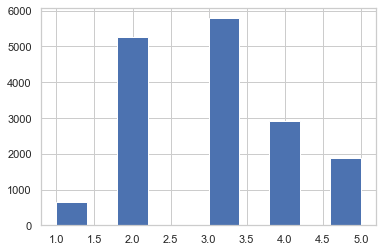

In [161]:
housing["income_cat"].hist()
plt.show()

**NOTE:** Figure out how to fix the spacing on this histogram. TF is that?

Now we can perform stratified sampling based on income category.

In [100]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [101]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

**NOTE:** Might be worth investigating how `StratifiedShuffleSplit` works behind the scenes.

We only needed the `income_cat` attribute to create stratified train- and test sets, se we can drop the column now:

In [102]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

# Discover and Visualize the Data to Gain Insights

In [103]:
housing = strat_train_set.copy() # Create a copy to play around with without fear of messing up the original

## Visualizing Geographical Data

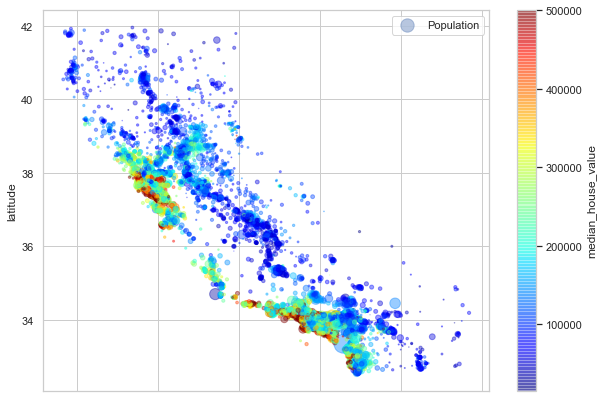

In [162]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"] / 100, label = "Population", figsize = (10, 7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True
)
plt.legend()
plt.show()

## Looking for Correlations

Correlation between two attributes can be measured using the _standard correlation coefficient_, also called _Pearson's r_, which can be calculated using
$$
r = \frac{(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}.
$$

As you would expect, this is computationally expensive, so it's more useful for small datasets (like the housing dataset we are using).

Luckily, Pandas comes with the `corr()` method that calculates the standard correlation coefficient matrix for a dataset, so we don't have to type out the whole formula:

In [116]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

It should be noted that the correlation coefficient only measures _linear_ correlation. That is, whether $ y $ _generally_ goes up or down with respect to $ x $.

Another way to check for correlation between attribute pairs is using the Pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute.

In our case, there are 11 numerical attributes, which would result in 121 plots. Seems rather cumbersome. Instead, we can choose to focus on the few that the `corr_matrix` tells us have a strong correlation with `median_house_value`:

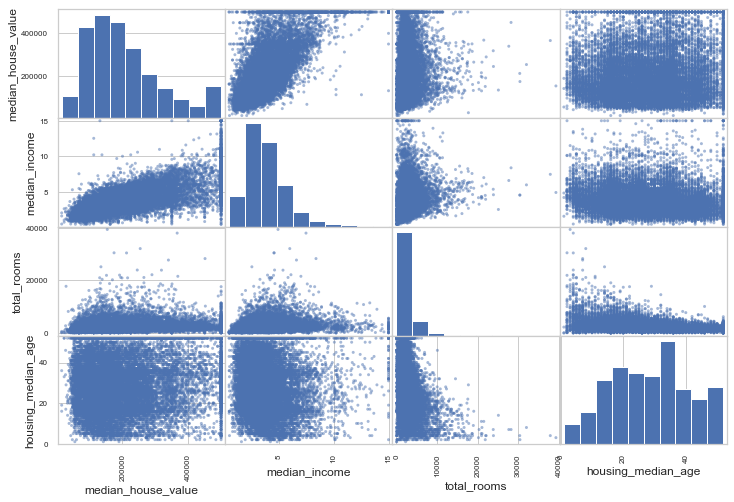

In [163]:
from pandas.plotting import scatter_matrix

attributes = [ "median_house_value", "median_income", "total_rooms", "housing_median_age" ]

scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

Notice that Pandas doesn't plot each attribute against itself, which would just result is a straight, diagonal line, and not be useful. Instead, it provides a histogram of each attribute. Thanks, Pandas!

The median house value seems to be most strongly correlated with median income, so let's focus on that plot:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


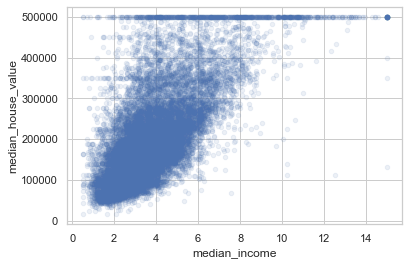

In [164]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)
plt.show()

## Experimenting with Attribute Combinations

In [165]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [166]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

Creating new features was illuminating: now we see that the number of bedrooms per room has a pretty strong correlation with median house value. The correlation coefficient is negative, which makes sense: if there are few rooms (i.e. if the house is smaller) then bedrooms will make up a higher portion of the rooms.